# ADCP Assessment 2.2: ADCP in the Sky

At the time that this notebook was created, there was an issue with the ADCP data displayed on the OOI Data Explorer (DE). The y-axis of pcolormesh plots on DE for ADCP time series have depths up to -500 m which puts these measurements "in the Sky". In this notebook, I will compare the datasets available from the Data Explorer ERDDAP server with datasets for the same sensors from OOINet. We hope this will clarify where the issue is in the data pipeline.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from ooi_data_explorations.common import load_gc_thredds
from ooi_data_explorations.combine_data import combine_datasets

## Global Station PAPA Array: GP03FLMB-RIM01-02-ADCPSL007

### Dataset from Data Explorer ERDDAP server

In [2]:
# Load datasets from DE ERDDAP server 
# CSV imported into MultiIndex data frame
# gp_de_file = "~/code/qartod_testing/data/external/adcp_in_the_sky/ooi-gp03flmb-rim01-02-adcpsl007_ca5d_930f_6a0f.csv" # July 2013-June 2014
gp_de_file = "~/code/qartod_testing/data/external/adcp_in_the_sky/ooi-gp03flmb-rim01-02-adcpsl007_cf08_89fa_14e8.csv" # July 2013-2016
gp_de = pd.read_csv(gp_de_file, skiprows=[1], header=0, index_col=[0, 1], parse_dates=True)

The data we just imported was from this daily binned data view from Data Explorer: 
![GP03FLMB ADCP Jul 2013-2016](../data/external/adcp_in_the_sky/exported_chart_GP03FLMB_2013_2016.jpeg)

In [3]:
# Show contents of Global Station PAPA dataset from CSV
gp_de

eastward_sea_water_velocity  velprof_evl  \
time                      z                                                  
2013-07-24 07:26:00+00:00 -480.0                     0.120753       -0.002   
                          -470.0                     0.049463        0.007   
                          -460.0                     0.076618        0.052   
                          -450.0                     0.077163        0.005   
                          -440.0                     0.060183       -0.016   
...                                                       ...          ...   
2016-07-20 03:00:00+00:00 -11.0                      1.329435       -0.209   
                          -1.0                       1.382085        0.005   
                           9.0                       1.586498        0.334   
                           19.0                      2.024268          NaN   
                           49.0                      0.308178          NaN   

                                  velprof_err  northward_sea_water_velocity  \
time                      z                                                   
2013-07-24 07:26:00+00:00 -480.0          NaN                     -0.008474   
                          -470.0          NaN                     -0.016075   
                          -460.0          NaN                     -0.002379   
                          -450.0          NaN                     -0.010906   
                          -440.0          NaN                      0.008886   
...                                       ...                           ...   
2016-07-20 03:00:00+00:00 -11.0           NaN                     -1.125574   
                          -1.0            NaN                     -0.966977   
                           9.0            NaN                     -1.486265   
                           19.0           NaN                     -2.009225   
                           49.0           NaN                     -0.075573   

                                  upward_sea_water_velocity  
time                      z                                  
2013-07-24 07:26:00+00:00 -480.0                     -0.007  
                          -470.0                     -0.015  
                          -460.0                     -0.016  
                          -450.0                     -0.019  
                          -440.0                     -0.014  
...                                                     ...  
2016-07-20 03:00:00+00:00 -11.0                      -0.275  
                          -1.0                       -0.070  
                           9.0                        0.074  
                           19.0                      -0.100  
                           49.0                      -0.034  

[1742758 rows x 5 columns]

In [3]:
# Convert data frame to dataset
gp_de_ds = xr.Dataset.from_dataframe(gp_de)

# Need to convert the time coordinate as a datetime data type
gp_de_ds = gp_de_ds.assign_coords(time=(gp_de_ds.time.astype('datetime64[ns]')))

# Check contents
gp_de_ds

<xarray.Dataset>
Dimensions:                       (time: 26106, z: 624)
Coordinates:
  * time                          (time) datetime64[ns] 2013-07-24T07:26:00 ....
  * z                             (z) float64 -541.0 -537.0 ... 486.0 496.0
Data variables:
    eastward_sea_water_velocity   (time, z) float64 nan nan nan ... nan nan nan
    velprof_evl                   (time, z) float64 nan nan nan ... nan nan nan
    velprof_err                   (time, z) float64 nan nan nan ... nan nan nan
    northward_sea_water_velocity  (time, z) float64 nan nan nan ... nan nan nan
    upward_sea_water_velocity     (time, z) float64 nan nan nan ... nan nan nan

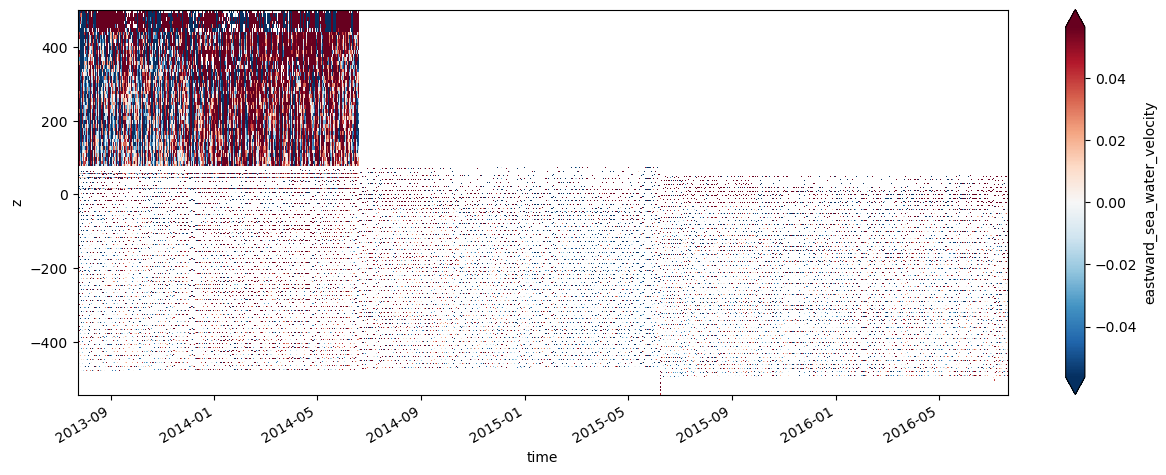

In [22]:
# Plot 2D eastward_sea_water_velocity variable
gp_de_ds["eastward_sea_water_velocity"].plot.pcolormesh(x="time", figsize=[15, 5], vmax=gp_de_ds["eastward_sea_water_velocity"].mean())

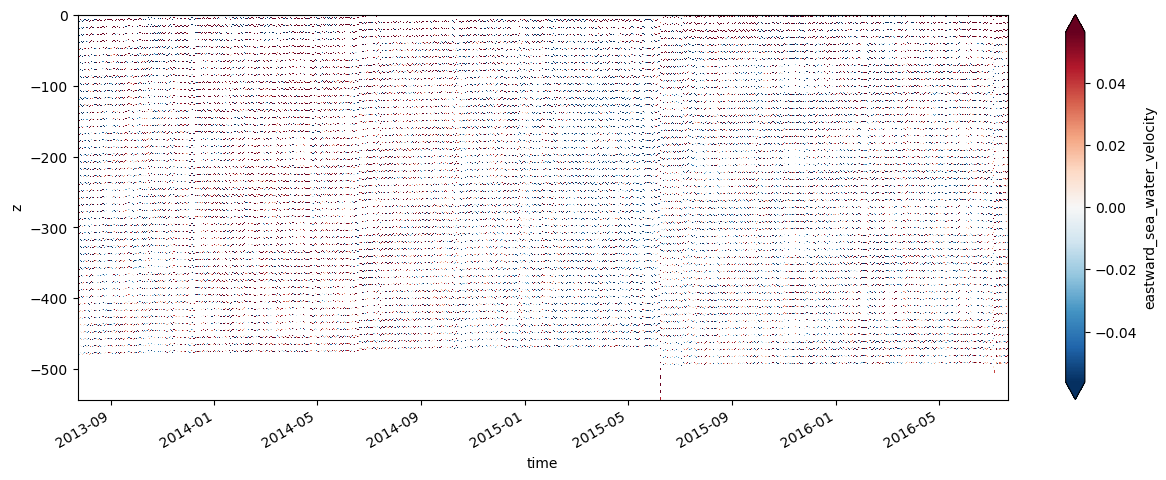

In [23]:
# Plot 2D eastward_sea_water_velocity variable for cell depths below the sea surface
gp_de_ds["eastward_sea_water_velocity"].sel(z=slice(0)).plot.pcolormesh(x="time", figsize=[15, 5], vmax=gp_de_ds["eastward_sea_water_velocity"].mean())

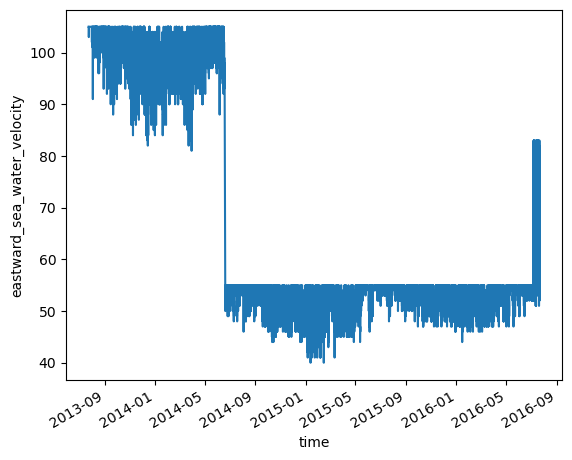

In [31]:
# Check and plot number of cells with data at each time step
numcells = gp_de_ds["eastward_sea_water_velocity"].count(dim="z")
numcells.plot()

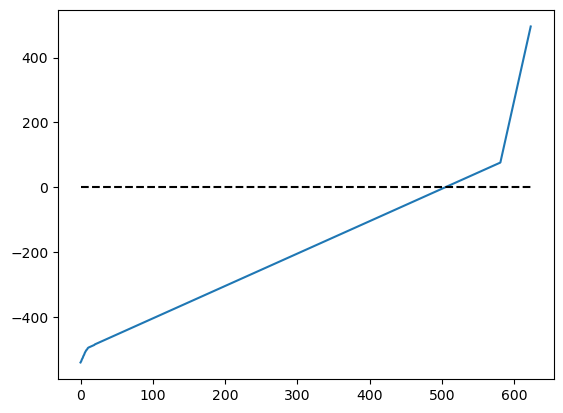

In [30]:
# Plot cell depths 
plt.plot(np.arange(gp_de_ds["z"].size), gp_de_ds["z"])
plt.hlines(0, 0, gp_de_ds["z"].size, colors='black', linestyles='dashed')

We expect some variation in cell depths between deployments, so the depth range with more cells per unit depth is the typical depth range for the ADCPS at this location.

### Compare data in the sky with depth-corrected data

In [116]:
# Index one time slice from Global PAPA dataset 
gpDE_1time = gp_de_ds.sel(time="2013-09-01T00:26:00").dropna(dim='z', how='all')
gpDE_1time

<xarray.Dataset>
Dimensions:                       (z: 103)
Coordinates:
    time                          datetime64[ns] 2013-09-01T00:26:00
  * z                             (z) float64 -477.0 -467.0 ... 486.0 496.0
Data variables:
    eastward_sea_water_velocity   (z) float64 0.01765 -0.04412 ... 0.2998 0.5689
    velprof_evl                   (z) float64 -0.052 -0.028 -0.021 ... 0.05 nan
    velprof_err                   (z) float64 nan nan nan nan ... nan nan nan
    northward_sea_water_velocity  (z) float64 0.03749 0.04056 ... -1.898 -1.941
    upward_sea_water_velocity     (z) float64 0.006 0.008 ... 0.018 -0.062

In [22]:
# Attempt to plot autocorrelation matrix of eastward sea water velocity with depth 
# (when I don't remember if it is possible to do this in one dimension)
outerprod = np.outer(gpDE_1time['eastward_sea_water_velocity'], gpDE_1time['eastward_sea_water_velocity'])
# outerprod

normalizedmaybe = np.zeros_like(outerprod)
for i, x in enumerate(outerprod): 
    normalizedmaybe[i] = x/(gpDE_1time['eastward_sea_water_velocity'][i].values**2)
# normalizedmaybe

sns.heatmap(normalizedmaybe, vmax=1, vmin=-1, center=0, square=True)

In [20]:
# Plot eastward velocity at depths below surface (x-axis) against eastward velocity
# at elevations above the surface (y-axis) with a line showing a 1:1
# relationship in the background.
eastvel_water = gpDE_1time["eastward_sea_water_velocity"].sel(z=slice(20)) 
# elevation of 20 m is within possible "normal" cell depth range
# and makes the water and sky sections nearly equal
eastvel_sky = gpDE_1time["eastward_sea_water_velocity"].sel(z=slice(20, 500))[1: ]

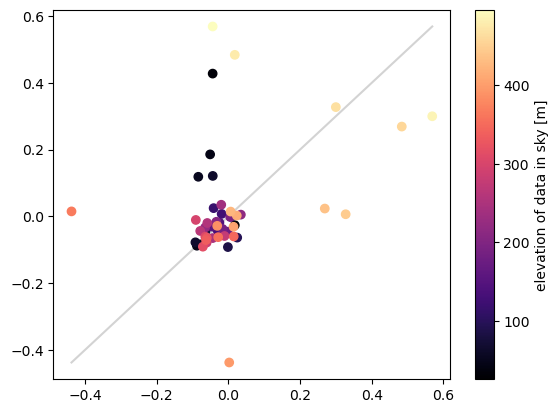

In [31]:
fig, ax = plt.subplots(1, 1)
plt.scatter(eastvel_water.values, eastvel_sky.values, c=eastvel_sky['z'].values, cmap='magma')
plt.colorbar(label="elevation of data in sky [m]")
xval = np.linspace(min(eastvel_water.values), max(eastvel_water.values), 50)
plt.plot(xval, xval, c="lightgray", zorder=-1)

So the plot above didn't work as well as I hoped because most of the points are near zero anyway. I guess there aren't many values in the upper left or lower right corners, so it's not like it couldn't be a 1:1 relationship. We just can't really get there from this.

Using these variables for eastward sea water velocity that I have now, I am going to try just plotting the velocity as a function of depth.

Text(0, 0.5, 'eastward sea water velocity [m s$^{-1}$?]')

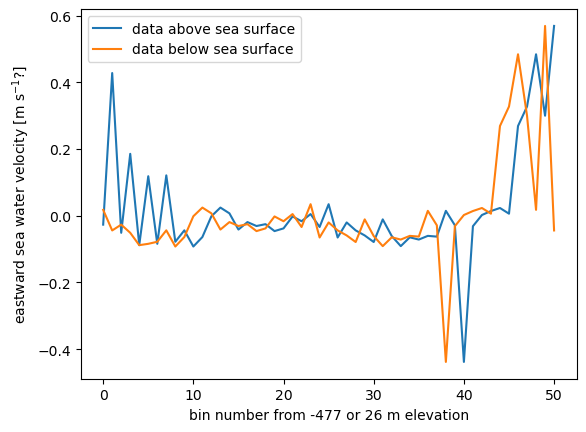

In [43]:
fig, ax = plt.subplots(1, 1)
plt.plot(eastvel_sky.values, label="data above sea surface")
plt.plot(eastvel_water.values, label="data below sea surface")
plt.legend()
ax.set_xlabel("bin number from -477 or 26 m elevation")
ax.set_ylabel("eastward sea water velocity [m s$^{-1}$?]")

Text(0, 0.5, 'eastward sea water velocity [m s$^{-1}$?]')

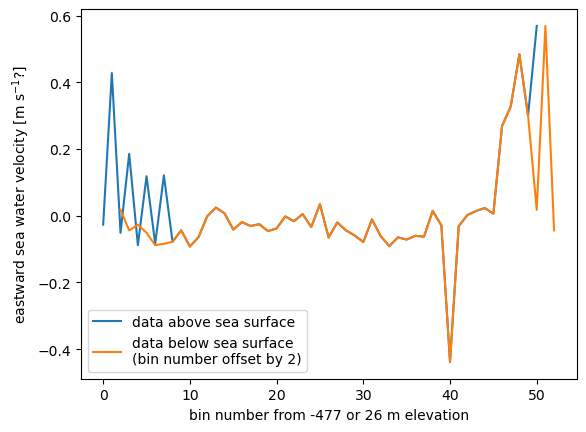

In [42]:
fig, ax = plt.subplots(1, 1)
plt.plot(eastvel_sky.values, label="data above sea surface")
plt.plot(np.arange(len(eastvel_water))+2, eastvel_water.values, label="data below sea surface \n(bin number offset by 2)")
plt.legend()
ax.set_xlabel("bin number from -477 or 26 m elevation")
ax.set_ylabel("eastward sea water velocity [m s$^{-1}$?]")

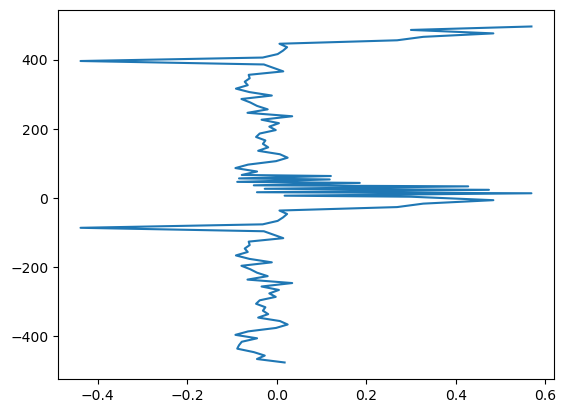

In [44]:
# quick plot of the eastward velocity profile as a function of elevation
plt.plot(gpDE_1time["eastward_sea_water_velocity"], gpDE_1time["z"])

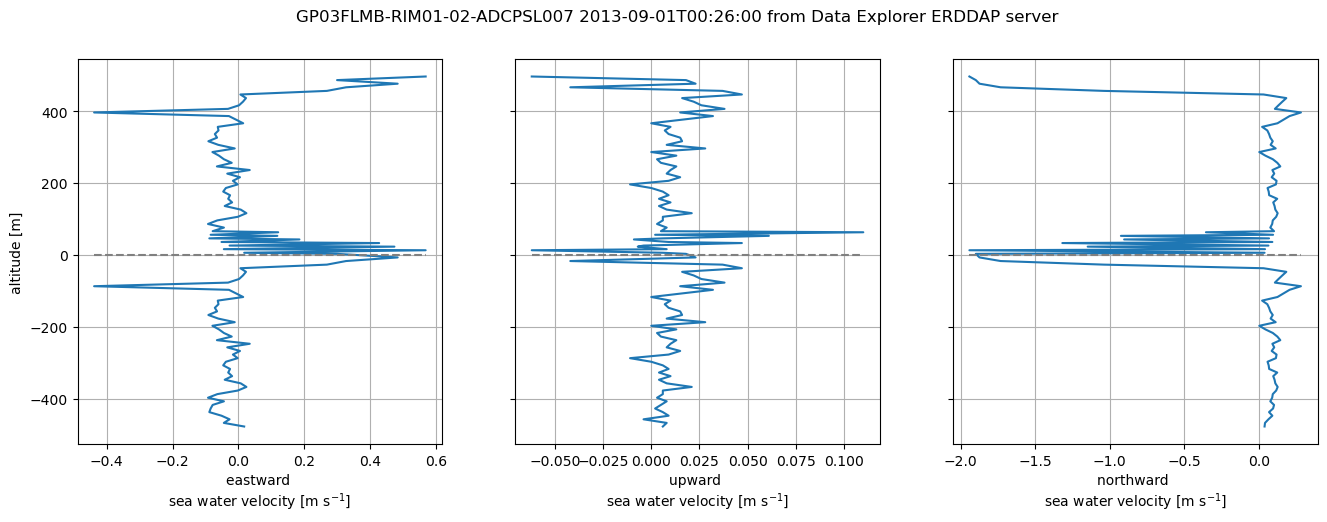

In [69]:
# quick plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_1time["eastward_sea_water_velocity"].min().values
hline1x1 = gpDE_1time["eastward_sea_water_velocity"].max().values
hline2x0 = gpDE_1time["upward_sea_water_velocity"].min().values
hline2x1 = gpDE_1time["upward_sea_water_velocity"].max().values
hline3x0 = gpDE_1time["northward_sea_water_velocity"].min().values
hline3x1 = gpDE_1time["northward_sea_water_velocity"].max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_1time["eastward_sea_water_velocity"], gpDE_1time["z"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_1time["upward_sea_water_velocity"], gpDE_1time["z"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_1time["northward_sea_water_velocity"], gpDE_1time["z"])
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')
axs[0].set_ylabel("altitude [m]")
plt.suptitle("GP03FLMB-RIM01-02-ADCPSL007 2013-09-01T00:26:00 from Data Explorer ERDDAP server")
plt.show()

### Dataset from OOI Gold Copy

In [27]:
# Initialize parameters for gold copy data request from OOINet
gp_refdes = "GP03FLMB-RIM01-02-ADCPSL007"
gpsite, gpnode, gpsensor = gp_refdes.split("-", 2)

In [29]:
# Request telemtered, recovered host, and recovered instrument data to
# combine. The DE dataset of all deployments combines all delivery
# methods.
gptelem = load_gc_thredds(gpsite, gpnode, gpsensor, "telemetered", "adcps_jln_sio_mule_instrument", tag=".*ADCP.*\.nc$")
gphost = load_gc_thredds(gpsite, gpnode, gpsensor, "recovered_host", "adcps_jln_sio_mule_instrument", tag=".*ADCP.*\.nc$")
gpinst = load_gc_thredds(gpsite, gpnode, gpsensor, "recovered_inst", "adcp_velocity_earth", tag=".*ADCP.*\.nc$")

In [30]:
# Combine data delivery methods into a single dataset
gp_gc = combine_datasets(gptelem, gphost, gpinst, None)

In [59]:
# Create similar velocity profiles from gold copy data for the same timestamp
gpGC_1time = gp_gc.sel(time="2013-09-01T00:26:00", method="nearest")

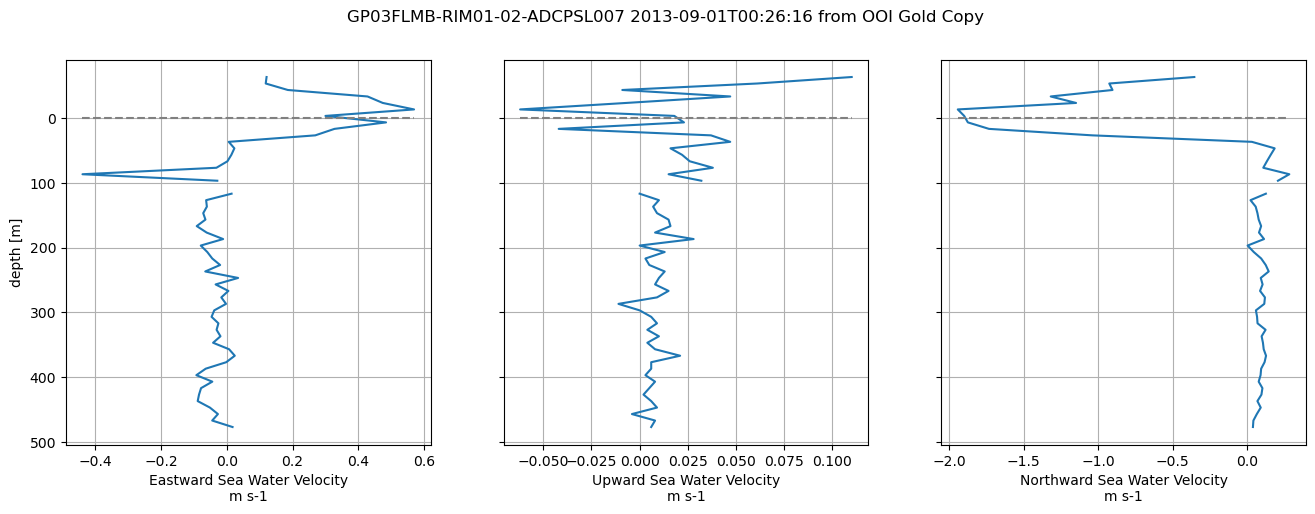

In [68]:
# plot of the eastward, northward, and upward velocity profile as a function of depth
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
ax = 0
for var in gpGC_1time.variables:
    if "ward_seawater_velocity" in var:
        if ax < 3:
            velprofile = gpGC_1time[var]
            velprofile = velprofile.where(velprofile.values>velprofile._FillValue)
            hlinex0 = velprofile.min().values
            hlinex1 = velprofile.max().values

            plt.subplot(1, 3, ax+1)
            plt.grid(visible=True)
            plt.plot(velprofile.values, gpGC_1time["bin_depths"].values)
            axs[ax].invert_yaxis()
            axs[ax].set_xlabel(velprofile.long_name +"\n"+ velprofile.units)
            plt.hlines(0, hlinex0, hlinex1, colors='gray', linestyles='dashed')

            ax += 1

        else:
            continue
    else:
        continue
axs[0].set_ylabel("depth [m]")
plt.suptitle("GP03FLMB-RIM01-02-ADCPSL007 {timestamp:.19} from OOI Gold Copy".format(timestamp=gpGC_1time["time"].values))
plt.show()

### Compare Gold Copy and DE ERDDAP datasets

Now that we have all of our combined-stream datasets loaded into the notebook, we can check the range of depths in each dataset, and depth timeseries. There are four depth type parameters in the combined gold copy datasets: two with no instrument source in the attributes(`depth_from_pressure` and `non_zero_depth`) and two from the co-located CTDMO (`ctdmo_ghqr_sio_mule_instrument-depth` and `depth`). 
The datasets from the DE ERDDAP server have just one depth-type parameter: `z`.

In [19]:
# Check ranges of depth parameters
print(f"Station PAPA z range from DE:[{gp_de['z'].min()}, {gp_de['z'].max()}]")
print(f"Southern Ocean z range from DE:{np.ptp(gs_de['z'].values)}")

Station PAPA z range from DE:[<xarray.DataArray 'z' ()>
array(0.), <xarray.DataArray 'z' ()>
array(0.)]
Southern Ocean z range from DE:0.0


In [31]:
# Check ranges of gold copy depth parameters
print(f"Station PAPA depth_from_pressure range from DE:[{gp_gc['depth_from_pressure'].min().values}, {gp_gc['depth_from_pressure'].max().values}]")
print(f"Southern Ocean depth_from_pressure range from DE:[{gs_gc['depth_from_pressure'].min().values}, {gs_gc['depth_from_pressure'].max().values}]")

print(f"Station PAPA non_zero_depth range from DE:[{gp_gc['non_zero_depth'].min().values}, {gp_gc['non_zero_depth'].max().values}]")
print(f"Southern Ocean non_zero_depth range from DE:[{gs_gc['non_zero_depth'].min().values}, {gs_gc['non_zero_depth'].max().values}]")

print(f"Station PAPA ctdmo_ghqr_sio_mule_instrument-depth range from DE:[{gp_gc['ctdmo_ghqr_sio_mule_instrument-depth'].min().values}, {gp_gc['ctdmo_ghqr_sio_mule_instrument-depth'].max().values}]")
# print(f"Southern Ocean ctdmo_ghqr_sio_mule_instrument-depth range from DE:[{gs_gc['ctdmo_ghqr_sio_mule_instrument-depth'].min().values}, {gs_gc['ctdmo_ghqr_sio_mule_instrument-depth'].max().values}]")

print(f"Station PAPA depth range from DE:[{gp_gc['depth'].min().values}, {gp_gc['depth'].max().values}]")
# print(f"Southern Ocean depth range from DE:[{gs_gc['depth'].min().values}, {gs_gc['depth'].max().values}]")

Station PAPA depth_from_pressure range from DE:[481.8108615552479, 557.467162700832]
Southern Ocean depth_from_pressure range from DE:[18.897096405406707, 505.66615180355086]
Station PAPA non_zero_depth range from DE:[481.8108615552479, 557.467162700832]
Southern Ocean non_zero_depth range from DE:[18.897096405406707, 505.66615180355086]
Station PAPA ctdmo_ghqr_sio_mule_instrument-depth range from DE:[171.24286632302181, 565.9338353985949]
Station PAPA depth range from DE:[1.00874583311923, 565.9338353985949]


In [108]:
# What about the same DE ERDDAP velocity profile as above but I subtract the part that is in the water (including a little above the surface)?
# revisit this after comparing with goldcopy data 
# Is it the same as the gold copy data?
# plot of DE ERDDAP dataset with Gold Copy data subtracted from section of profile below the sea surface
gpDE_east = gpDE_1time["eastward_sea_water_velocity"]
gpGC_east = gpGC_1time["eastward_seawater_velocity"].where(gpGC_1time["eastward_seawater_velocity"]>velprofile._FillValue)
gpGC_east = gpGC_east.where(gpGC_1time["bin_depths"]>=0, drop=True)
end = len(gpGC_east) + 1
gpDE_east[-end:-1] = gpDE_east[-end:-1] - gpGC_east.values

gpDE_up = gpDE_1time["upward_sea_water_velocity"]
gpGC_up = gpGC_1time["upward_seawater_velocity"].where(gpGC_1time["upward_seawater_velocity"]>velprofile._FillValue)
gpGC_up = gpGC_up.where(gpGC_1time["bin_depths"]>=0, drop=True)
end = len(gpGC_up) + 1
gpDE_up[-end:-1] = gpDE_up[-end:-1] - gpGC_up.values

gpDE_north = gpDE_1time["northward_sea_water_velocity"]
gpGC_north = gpGC_1time["northward_seawater_velocity"].where(gpGC_1time["northward_seawater_velocity"]>velprofile._FillValue)
gpGC_north = gpGC_north.where(gpGC_1time["bin_depths"]>=0, drop=True)
end = len(gpGC_north) + 1
gpDE_north[-end:-1] = gpDE_north[-end:-1] - gpGC_north.values


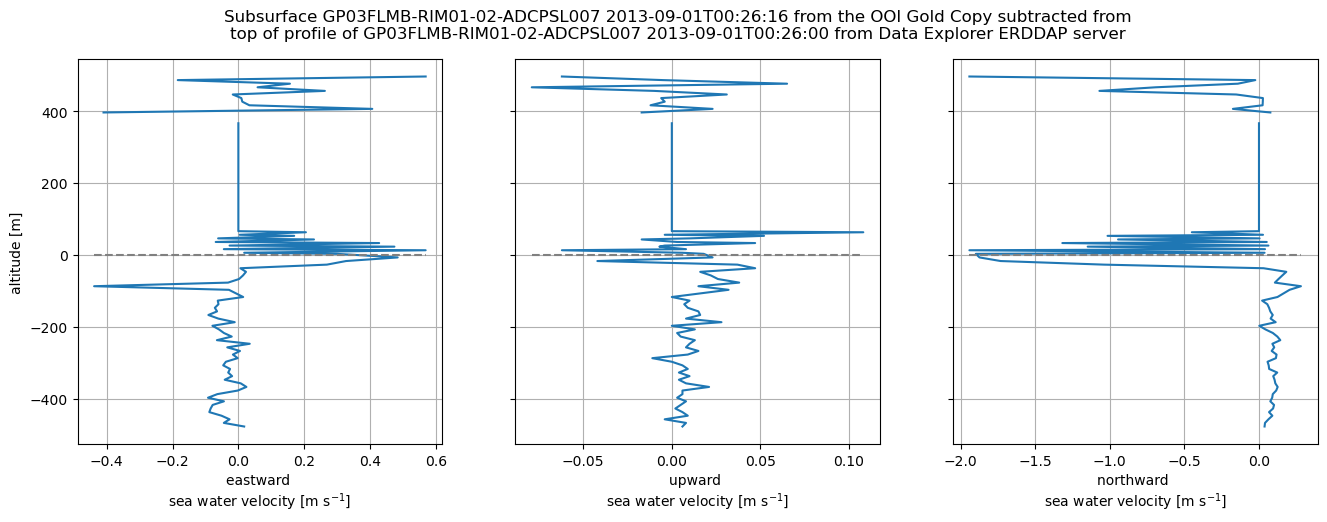

In [109]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_east.min().values
hline1x1 = gpDE_east.max().values
hline2x0 = gpDE_up.min().values
hline2x1 = gpDE_up.max().values
hline3x0 = gpDE_north.min().values
hline3x1 = gpDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_east.values, gpDE_east["z"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_up.values, gpDE_1time["z"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_north.values, gpDE_north["z"])
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')
axs[0].set_ylabel("altitude [m]")
plt.suptitle("Subsurface GP03FLMB-RIM01-02-ADCPSL007 2013-09-01T00:26:16 from the OOI Gold Copy subtracted from\ntop of profile of GP03FLMB-RIM01-02-ADCPSL007 2013-09-01T00:26:00 from Data Explorer ERDDAP server")
plt.show()

In [101]:
# plot of DE ERDDAP dataset with Gold Copy data subtracted from section of profile below the sea surface
gpDE_east = gpDE_1time["eastward_sea_water_velocity"]
gpGC_east = gpGC_1time["eastward_seawater_velocity"].where(gpGC_1time["eastward_seawater_velocity"]>velprofile._FillValue)
gpDE_east[0:55] = gpDE_east[0:55] - gpGC_east.values
gpDE_up = gpDE_1time["upward_sea_water_velocity"]
gpGC_up = gpGC_1time["upward_seawater_velocity"].where(gpGC_1time["upward_seawater_velocity"]>velprofile._FillValue)
gpDE_up[0:55] = gpDE_up[0:55] - gpGC_up.values
gpDE_north = gpDE_1time["northward_sea_water_velocity"]
gpGC_north = gpGC_1time["northward_seawater_velocity"].where(gpGC_1time["northward_seawater_velocity"]>velprofile._FillValue)
gpDE_north[0:55] = gpDE_north[0:55] - gpGC_north.values

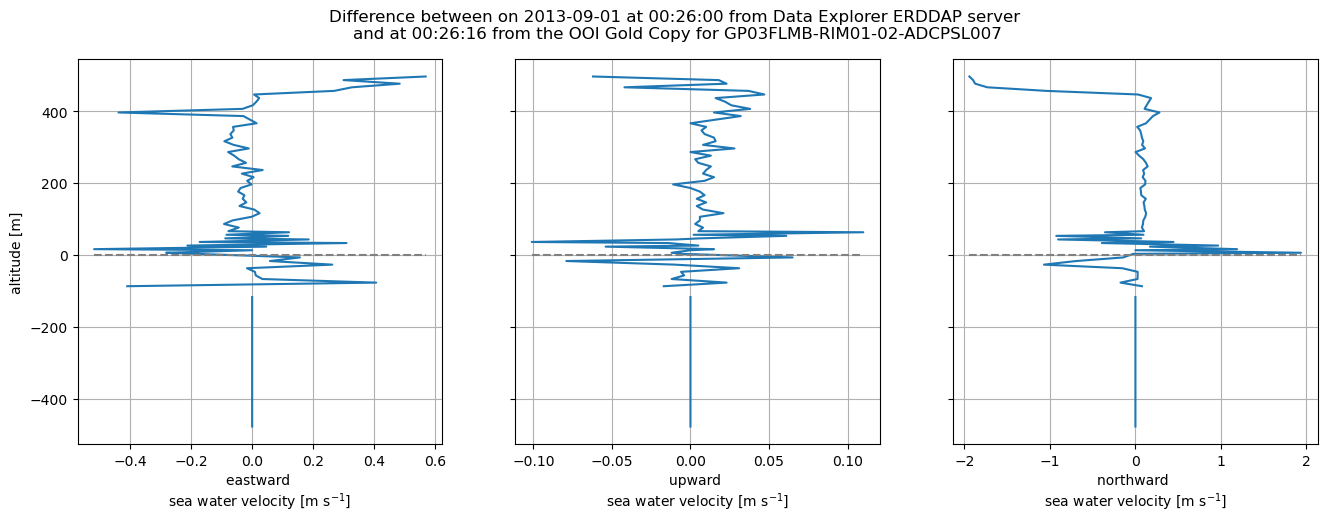

In [102]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_east.min().values
hline1x1 = gpDE_east.max().values
hline2x0 = gpDE_up.min().values
hline2x1 = gpDE_up.max().values
hline3x0 = gpDE_north.min().values
hline3x1 = gpDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_east.values, gpDE_east["z"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_up.values, gpDE_1time["z"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')
plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_north.values, gpDE_north["z"])
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')
axs[0].set_ylabel("altitude [m]")
plt.suptitle("Difference between on 2013-09-01 at 00:26:00 from Data Explorer ERDDAP server \nand at 00:26:16 from the OOI Gold Copy for GP03FLMB-RIM01-02-ADCPSL007")
plt.show()

In [117]:
# Plot of DE ERDDAP dataset with Gold Copy data overlay
gpDE_east = gpDE_1time["eastward_sea_water_velocity"]
gpGC_east = gpGC_1time["eastward_seawater_velocity"].where(gpGC_1time["eastward_seawater_velocity"]>velprofile._FillValue)

gpDE_up = gpDE_1time["upward_sea_water_velocity"]
gpGC_up = gpGC_1time["upward_seawater_velocity"].where(gpGC_1time["upward_seawater_velocity"]>velprofile._FillValue)

gpDE_north = gpDE_1time["northward_sea_water_velocity"]
gpGC_north = gpGC_1time["northward_seawater_velocity"].where(gpGC_1time["northward_seawater_velocity"]>velprofile._FillValue)

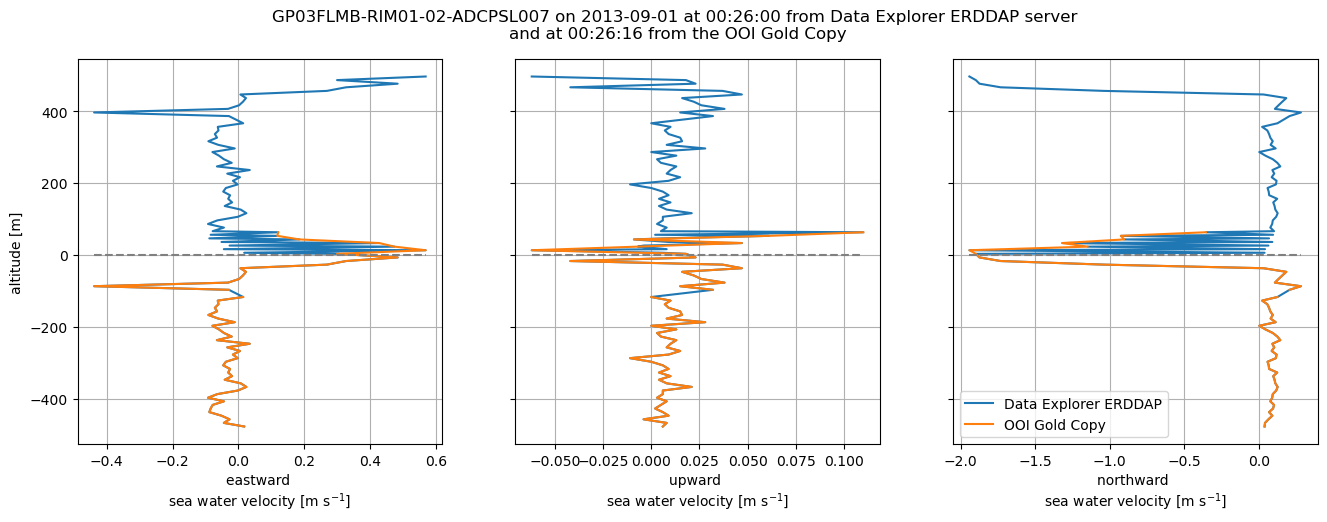

In [120]:
# plot of the eastward, northward, and upward velocity profile as a function of altitude
hline1x0 = gpDE_east.min().values
hline1x1 = gpDE_east.max().values
hline2x0 = gpDE_up.min().values
hline2x1 = gpDE_up.max().values
hline3x0 = gpDE_north.min().values
hline3x1 = gpDE_north.max().values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.grid(visible=True)
plt.plot(gpDE_east.values, gpDE_east["z"])
plt.plot(gpGC_east.values, -1*gpGC_1time["bin_depths"])
axs[0].set_xlabel("eastward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline1x0, hline1x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 2)
plt.grid(visible=True)
plt.plot(gpDE_up.values, gpDE_1time["z"])
plt.plot(gpGC_up.values, -1*gpGC_1time["bin_depths"])
axs[1].set_xlabel("upward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline2x0, hline2x1, colors='gray', linestyles='dashed')

plt.subplot(1, 3, 3)
plt.grid(visible=True)
plt.plot(gpDE_north.values, gpDE_north["z"], label="Data Explorer ERDDAP")
plt.plot(gpGC_north.values, -1*gpGC_1time["bin_depths"], label="OOI Gold Copy")
axs[2].set_xlabel("northward \nsea water velocity [m s$^{-1}$]")
plt.hlines(0, hline3x0, hline3x1, colors='gray', linestyles='dashed')

axs[0].set_ylabel("altitude [m]")
plt.suptitle("GP03FLMB-RIM01-02-ADCPSL007 on 2013-09-01 at 00:26:00 from Data Explorer ERDDAP server \nand at 00:26:16 from the OOI Gold Copy")
plt.legend()
plt.show()

## Global Southern Ocean Array: GS01SUMO-RII11-02-ADCPSN010

### Dataset from Data Explorer ERDDAP server

In [ ]:
# Load .nc file into xarray dataset
gs_de_file = "~/code/qartod_testing/data/external/adcp_in_the_sky/ooi-gs01sumo-rii11-02-adcpsn010_f9b4_6bbe_e00e.nc"
gs_de = xr.open_dataset(gs_de_file)
gs_de.set_coords("time")
gs_de = gs_de.swap_dims({"row": "time"})

### Dataset from OOI Gold Copy

In [ ]:
# Initialize parameters for gold copy data request from OOINet
gs_refdes = "GS01SUMO-RII11-02-ADCPSN010"
gssite, gsnode, gssensor = gs_refdes.split("-", 2)

In [ ]:
# Request telemtered, recovered host, and recovered instrument data to
# combine. The DE dataset of all deployments combines all delivery
# methods.
gstelem = load_gc_thredds(gssite, gsnode, gssensor, "telemetered", "adcps_jln_sio_mule_instrument")
gshost = load_gc_thredds(gssite, gsnode, gssensor, "recovered_host", "adcps_jln_sio_mule_instrument")
gsinst = load_gc_thredds(gssite, gsnode, gssensor, "recovered_inst", "adcp_velocity_earth")

In [ ]:
# Combine data delivery methods into a single dataset
gs_gc = combine_datasets(gstelem, gshost, gsinst, None)